image_entries []


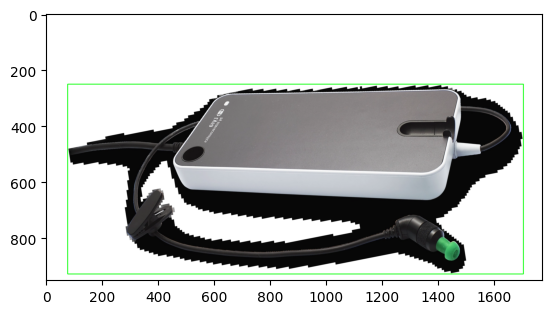

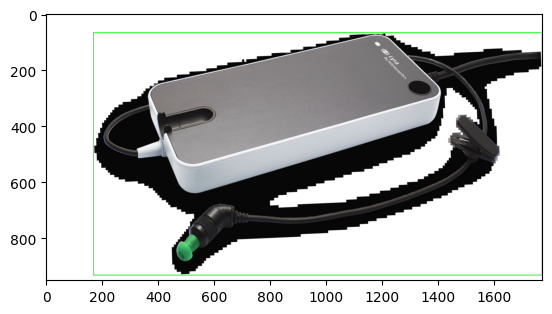

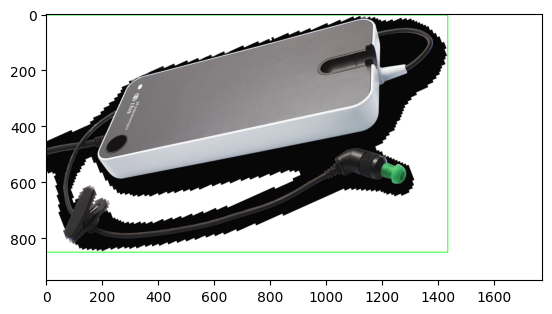

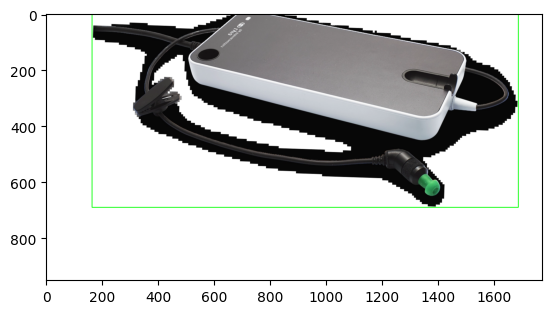

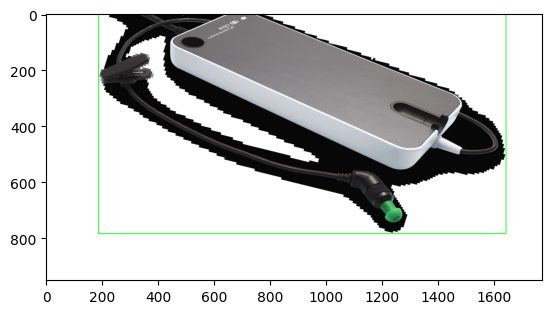

In [5]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch
from azure.cognitiveservices.vision.customvision.training.models import ImageRegion
from msrest.authentication import ApiKeyCredentials
import os
import cv2
import numpy as np
import random as rng
from dotenv import load_dotenv, dotenv_values 
import matplotlib.pyplot as plt

load_dotenv()

np.random.seed(12345)

'''
Authenticate
Authenticate your credentials and creates a client
'''

training_key = os.getenv('training_key')
endpoint = os.getenv('endpoint')
credentials=ApiKeyCredentials(in_headers={"Training-key": training_key})
project_id = os.getenv('project_id')
publish_iteration_name = "Iteration 1"

# Change this
root_folder= "C:\\Users\\nleo\\Downloads\\Output"
# publish_iteration_name = Detect

trainer = CustomVisionTrainingClient(endpoint, credentials)
remote_tags_name = []
tags=[]
tag_ids_for_curr_image = []

def return_as_dict(tag):
    if tag.name not in remote_tags_name:
        remote_tags_name.append(tag.name)

    return tag.as_dict()

def add_images_with_tags():
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        
        tag_ids_for_curr_image = []
        if os.path.isdir(folder_path):
            remote_tag_list = list(map(return_as_dict, trainer.get_tags(project_id=project_id)))

            if folder_name not in remote_tags_name:
                created_tag = trainer.create_tag(project_id, folder_name)
                tag_ids_for_curr_image.append(created_tag.id)
                tags.append(created_tag)

            elif folder_name in remote_tags_name:
                for remote_tag in remote_tag_list:
                    if remote_tag['name'] == folder_name:
                        tag_ids_for_curr_image.append(remote_tag['id'])
         
            image_entries=[]
            i=0
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
            
                if os.path.isfile(image_path):
                    image = cv2.imread(image_path)
                    
                    # Processes to change image color etc to make edges more detectable
                    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
                    equ = cv2.equalizeHist(blurred)
                    thresh = cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
                    kernel = np.ones((3, 3), np.uint8)
                    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
                    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

                    # Detect edges using Canny
                    canny = cv2.Canny(morph, 50, 150)

                    # Find contours
                    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    regions = [cv2.boundingRect(contour) for contour in contours]
                    outermost_rectangle = max(regions, key=lambda rect:rect[2]*rect[3])    
                    left, top, width, height = outermost_rectangle

                    cv2.rectangle(image, (left, top), (left + width, top + height), (0, 255, 0), 2)
                    if i < 5:
                        plt.figure(i)
                        imgplot = plt.imshow(image.astype('uint8'))

                    i += 1
                    # Uncomment this section to create Image entry and image region
                    # with open(image_path, "rb") as image_contents:
                    #     region = ImageRegion(
                    #         tag_id = tag_ids_for_curr_image[0],
                    #         left=left/image.shape[1],
                    #         top=top/image.shape[0],
                    #         width=width/image.shape[1],
                    #         height=height/image.shape[0]
                    #     )
                    #     image_entry = ImageFileCreateEntry(name=os.path.basename(image_path), contents=image_contents.read(), tag_ids=tag_ids_for_curr_image, regions=[region])
 
                    #     image_entries.append(image_entry)
            
            # Uncomment this section to upload
            # Upload images
            
            print(f"image_entries", image_entries)
            # if image_entries:
            #     batch_size = 64
            #     num_batches = (len(image_entries) + batch_size -1 ) // batch_size
            #     for batch in range(num_batches):
            #         start = batch * batch_size
            #         end = min((batch + 1) * batch_size, len(image_entries))
            #         sliced_image_entries = image_entries[start: end]
            #         upload_result = trainer.create_images_from_files(project_id, ImageFileCreateBatch(images=sliced_image_entries))
            #         if not upload_result.is_batch_successful:
            #             print(f"Image batch upload failed for tag '{folder_name}'")
            #             print(f"upload_result'{upload_result}'")
            #             for image_result in upload_result.images:
            #                 if image_result.status != 'OK':
            #                     print(f"image_result {image_result}")
            
add_images_with_tags()